## Towards comparing the signal-to-noise in different filter widths

## A detailed comparison of the UVES and Gemini sky spectra

How well do they agree?  Should we be using the UVES spectra instead of the Gemini sky spectra?

What sky lines are visible in Gemini, since seem to be way more visible in the UVES spectra than Gemini?

What is the change in the sky flux in different filter widths, in both the Gemini and UVES sky background spectra?

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from astropy import constants as const
from astropy import units as u
from astropy.io import fits

### determining the sky background

#### Gemini Sky Background data  
(http://www.gemini.edu/sciops/ObsProcess/obsConstraints/atm-models/skybg_50_10.dat)

sky background 0.3-1.0um

DARK optical sky - 50%ile conditions (day 7)

AM=1.0

derived from (reverse engineered ESO model) sky spectrum plus constant slope to match assumed photometric background (from von Hippel model.

#### UVES Sky Background data  
(http://www.eso.org/observing/dfo/quality/UVES/pipeline/sky_spectrum.html)

These spectra were selected for a bunch of criteria, including:
"minimal moon contamination fractional lunar illumination < 0.05 and moon distance > 90 deg)"

That means that the scaled Gemini spectra is better (unless we also scale the UVES spectra)

Note that there are a bunch of column leaks in the UVES spectra -- make sure take that into account if end up using the UVES spectra for line identification!
>The REDU (red upper) CCD suffered from a leaking column causing broad quasi-emission in the echelle order. These features have been easily recognized due to their known position and atypical width. They are marked by squared crosses in the plots.

In particular, leaky columns at:<br>
6341 Angstroms<br>
6407 Angstroms<br>
6575 Angstroms<br>
6545 Angstroms<br>
66l5 Angstroms<br>
6689 Angstroms<br>


#### Compare
Want to compare the UVES and Gemini sky spectra.  To do this need to convert to the same units:  photon / s / cm^2 / arcsec^2 / nm.

Gemini is in: photon / s / **m^2** / arcsec^2 / nm 

* (m / 100cm) ^2

UVES is in: 1e-16 **erg** / s / cm^2 / arcsec^2 / **Angstrom**

* 1 photon / ( h c / lambda ) erg
* 10 Angstrom / nm

In [182]:
## from reading the Gemini and UVES data in raw
## get them both into units of ph / s / nm / cm**2 / arcsec**2
#wavelen_GEM = wavelen_G
#flux_GEM = flux_G * (1/100.**2) # / m**2 --> / cm **2
#wavelen_UVES = wavelen_U / 10.  # Angs --> nm
#flux_UVES = flux_U *10**-16 * ((wavelen_UVES*10**-9)/(const.h.to('erg s').value * const.c.to('m/s').value)) * 10. # erg --> photon and / Ang --> / nm

In [2]:
def getBackgroundGemini(start,end,machine,plot=False,verbose=False):
    # Returns the total background flux in the wavlength interval supplied i.e. returns (flux)*(wavlength interval) 
    wavelength = []
    flux = []
    
    if machine=='chinook':
        geminiloc='/Users/lokhorst/Documents/Eagle/Gemini_skybackground.dat'
    elif machine=='coho':
        geminiloc='/Users/deblokhorst/Documents/Dragonfly/HalphaScripts/Gemini_skybackground.dat'
    
    with open(geminiloc,'r') as f:  #wavelength in nm, flux in phot/s/nm/arcsec^2/m^2
        for line in f:
            if line[0]!='#' and len(line)>5:
                tmp = line.split()
                wavelength.append(tmp[0])
                flux.append(tmp[1])
                
    wavelength = np.array(wavelength,'d')
    flux = np.array(flux,'d')
    
    start_ind = (np.abs(wavelength-start)).argmin()
    end_ind   = (np.abs(wavelength-end)).argmin()
        
    # if spacings are not even, need to add element by element
    total=0
    for index in np.arange(start_ind,end_ind):
      #  print index,index+1
      #  print total
        total = total+(flux[index]*(wavelength[index+1]-wavelength[index]))
    actualwavelenrangebefore = wavelength[end_ind+1]-wavelength[start_ind]
    if verbose:
        print actualwavelenrangebefore

    # slightly better
    total2=0
    for index in np.arange(start_ind,end_ind):
      #  print index,index+1
      #  print total
        total2 = total2 + (flux[index]*(wavelength[index+1]-wavelength[index])/2.) +\
                            (flux[index]*(wavelength[index]-wavelength[index-1])/2.)
            
    # same as total2
    fluxarray = flux[start_ind:end_ind]
    wavelenarray_left = wavelength[start_ind-1:end_ind-1]
    wavelenarray_cent = wavelength[start_ind:end_ind]
    wavelenarray_righ = wavelength[start_ind+1:end_ind+1]
    total3 = np.sum(fluxarray*(wavelenarray_righ-wavelenarray_left))/2.
           
    actualwavelenrange = np.mean([wavelenarray_cent[-1],wavelenarray_righ[-1]]) - \
                        np.mean([wavelenarray_left[0],wavelenarray_cent[0]])
    if verbose:
        print actualwavelenrange
        print end-start
        
    # scaling to match desired wavelength range, since resolution might not match up correctly
    total4 = total3 * (end-start)/actualwavelenrange
    
    if verbose:
        print 'COMPARE: %s and %s and %s and %s' % (total, total2, total3,total4)    

    if plot==True:
        plt.plot(wavelength[start_ind-100:end_ind+100],flux[start_ind-100:end_ind+100])
        top = max(flux[start_ind-100:end_ind+100])
        plt.plot([start,start,end,end,start],[0,top,top,0,0])
        plt.show()
        
    return total4,wavelength[start_ind:end_ind],flux[start_ind:end_ind]

In [3]:
def getBackgroundUVES(start,end,machine,plot=False,verbose=False):
    
    #start = start*10
    #end = end*10
    
    def getUVESBackground(filename):
        hdulist = fits.open(filename)
        flux = hdulist[0].data
    
        CRPIX1 = hdulist[0].header['CRPIX1']
        CRVAL1 = hdulist[0].header['CRVAL1']
        CDELT1 = hdulist[0].header['CDELT1']
        #print(CRPIX1,CRVAL1,CDELT1)
        hdulist.close()
        
        begin = CRVAL1 - CRPIX1*CDELT1   
        end = begin + len(flux)*CDELT1
        wavelength = np.arange(begin,end,CDELT1)
        #print(len(wavelength),len(flux))
        return wavelength,flux

    # Returns the total background flux in the wavlength interval supplied i.e. returns (flux)*(wavlength interval) 
    wavelength = []
    flux = []
    
    filename1 = "fluxed_sky_580U.fits"
    filename2 = "fluxed_sky_860L.fits"
    leakycolumns = [6340.5, 6407, 6475.5,6545, 6616, 6689,6763] # locations where should mask data
    # about 2 angstrom thick
    

    if machine=='coho':
        uvesloc = '/Users/deblokhorst/Dropbox/UVES_Sky_Background/UVES_sky_all/'
    elif machine =='chinook':
        uvesloc = '/Users/lokhorst/Dropbox/UVES_Sky_Background/UVES_sky_all/'
    else:
        print 'No machine specified!'
    
    wavelength_UVES1,flux_UVES1=getUVESBackground(uvesloc+filename1)
    wavelength_UVES2,flux_UVES2=getUVESBackground(uvesloc+filename2)

    if len(wavelength_UVES2)==(len(flux_UVES2)+1):
        if verbose:
            print('wavelength array is one element longer than the flux array.  Shortening the wavelength array.')
        wavelength_UVES2 = wavelength_UVES2[0:-1]
        
    wavelength = np.append(wavelength_UVES1[wavelength_UVES1<6700.],wavelength_UVES2[wavelength_UVES2>6700.])
    flux = np.append(flux_UVES1[wavelength_UVES1<6700.],flux_UVES2[wavelength_UVES2>6700.])
        
    wavelength = np.array(wavelength,'d')
    flux = np.array(flux,'d')
    
    # convert the units to nm and ph / s / nm / m**2 / arcsec**2
    wavelength = wavelength / 10.  
        # Angs --> nm
    flux = flux *10**-16 * ((wavelength*10**-9)/(const.h.to('erg s').value * const.c.to('m/s').value)) * 10. * (100/1)**2 
        # (erg --> photon) and (/ Ang --> / nm) and (/ cm**2 --> / m**2)
        
    start_ind = (np.abs(wavelength-start)).argmin()
    end_ind   = (np.abs(wavelength-end)).argmin()
        
    # if spacings are not even, need to add element by element
    total=0
    for index in np.arange(start_ind,end_ind):
        total = total+(flux[index]*(wavelength[index+1]-wavelength[index]))
        
    # slight better
    fluxarray = flux[start_ind:end_ind]
    wavelenarray_left = wavelength[start_ind-1:end_ind-1]
    wavelenarray_cent = wavelength[start_ind:end_ind]
    wavelenarray_righ = wavelength[start_ind+1:end_ind+1]
    total3 = np.sum(fluxarray*(wavelenarray_righ-wavelenarray_left))/2.
           
    actualwavelenrange = np.mean([wavelenarray_cent[-1],wavelenarray_righ[-1]]) - \
                        np.mean([wavelenarray_left[0],wavelenarray_cent[0]])
    if verbose:
        print actualwavelenrange
        print end-start
        
    # scaling to match desired wavelength range, since resolution might not match up correctly
    total4 = total3 * (end-start)/actualwavelenrange
    
    if verbose:
        print 'COMPARE: %s and %s and %s'%(total,total3,total4)
        
    if plot==True:
        plt.plot(wavelength[start_ind-100:end_ind+100],flux[start_ind-100:end_ind+100])
        top = max(flux[start_ind-100:end_ind+100])
        plt.plot([start,start,end,end,start],[0,top,top,0,0])
        plt.show()
        
    return total4,wavelength[start_ind:end_ind],flux[start_ind:end_ind]

In [4]:
def loadUVESlinelists(machine='coho'):
    if machine=='coho':
        homedir = '/Users/deblokhorst'
    elif machine =='chinook':
        homedir = '/Users/lokhorst'

    # UVES identified line lists
    line_wavelength = []
#    with open(homedir+'/Dropbox/UVES_Sky_Background/UVES_ident/gident_437.dat','r') as f:
#        for line in f:
#            if line[0]!='#' and len(line)>5:
#                tmp = line.split()
#                line_wavelength.append(tmp[1])
#    with open(homedir+'/Dropbox/UVES_Sky_Background/UVES_ident/gident_580L.dat','r') as f:
#        for line in f:
#            if line[0]!='#' and len(line)>5:
#                tmp = line.split()
#                line_wavelength.append(tmp[1])
    with open(homedir+'/Dropbox/UVES_Sky_Background/UVES_ident/gident_580U.dat','r') as f:
        for line in f:
            if line[0]!='#' and len(line)>5:
                tmp = line.split()
                line_wavelength.append(tmp[1])
    with open(homedir+'/Dropbox/UVES_Sky_Background/UVES_ident/gident_860L.dat','r') as f:
        for line in f:
            if line[0]!='#' and len(line)>5:
                tmp = line.split()
                line_wavelength.append(tmp[1])
    line_wavelength = np.array(line_wavelength,'d')
    
    return line_wavelength


In [5]:
def datareduce(data,factor,method = 'average'):
    if len(data)%factor != 0:
        print('Output data must have a integer number of cells: cannot reduce image pixels by a factor %i'%factor)
        return None
    data = np.split(data,len(data)/factor)
    data = np.sum(data,axis=-1)
    if method == 'average':
        data = data/np.float(factor)
    return data

In [6]:
plt.style.use('seaborn-dark-palette')
plt.style.use('ggplot')
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}
import matplotlib
matplotlib.rc('font', **font)

In [7]:
machine = 'chinook'

In [8]:
## compare spectral resolution of Gemini vs UVES sky spectra

start_1 = 656.
end_1 = 658.
total_G,wavelen_G,flux_G = getBackgroundGemini(start_1,end_1,machine,plot=False);
total_U,wavelen_U,flux_U = getBackgroundUVES(start_1,end_1,machine,plot=False);

print 'A couple example of wavelength points for Gemini: %s,%s,%s' %(wavelen_G[0],wavelen_G[1],wavelen_G[2])
print 'Delta wavelength for Gemini: %s, %s' %(wavelen_G[2]-wavelen_G[1],wavelen_G[1]-wavelen_G[0])
print 'A couple example of wavelength points for UVES: %s,%s,%s' %(wavelen_U[0],wavelen_U[1],wavelen_U[2])
print 'Delta wavelength for UVES: %s, %s' %(wavelen_U[2]-wavelen_U[1],wavelen_U[1]-wavelen_U[0])
print ''
print 'Fraction higher resolution of UVES than Gemini is: %.1f' %\
        ((wavelen_G[2]-wavelen_G[1])/(wavelen_U[2]-wavelen_U[1]))

A couple example of wavelength points for Gemini: 656.1,656.37,656.63
Delta wavelength for Gemini: 0.26, 0.27
A couple example of wavelength points for UVES: 655.998354,656.001836,656.005318
Delta wavelength for UVES: 0.00348199999996, 0.00348199999996

Fraction higher resolution of UVES than Gemini is: 74.7


In [9]:
line_wavelengths = loadUVESlinelists(machine=machine)

Gemini and UVES total flux of sky background within 650.0 nm and 670.0 nm: 	 9.77087063552, 7.41528167521



/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:32: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:33: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


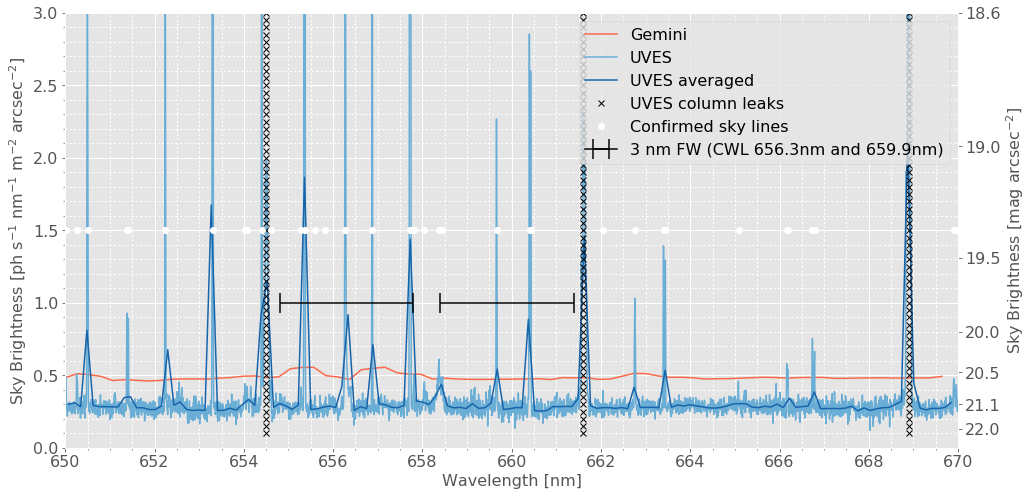

In [41]:
SMALL_SIZE = 16
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

reds = plt.get_cmap("Reds")
blues = plt.get_cmap("Blues")

# Start off the plot with the basic curves
start_1 = 650.
end_1 = 670.
total_G,wavelen_G,flux_G = getBackgroundGemini(start_1,end_1,machine,plot=False);
total_U,wavelen_U,flux_U = getBackgroundUVES(start_1,end_1,machine,plot=False);
print 'Gemini and UVES total flux of sky background within %s nm and %s nm: \t %s, %s\n'%\
        (start_1,end_1, total_G, total_U)

f, ax = plt.subplots(1,1,figsize = (16,8))
ax.plot(wavelen_G,flux_G,label='Gemini',color=reds(0.5))
ax.plot(wavelen_U,flux_U,label='UVES',color=blues(0.5))

factor=40
lim = -1. * (len(flux_U)%factor)
#print len(flux_U)%factor
#print len(flux_U[:lim])
if lim!=0:
    fluxsum = datareduce(flux_U[:lim],factor,method='average')
    wavelensum = datareduce(wavelen_U[:lim],factor)
else:
    fluxsum = datareduce(flux_U,factor,method='average')
    wavelensum = datareduce(wavelen_U,factor)

ax.plot(wavelensum,fluxsum,label='UVES averaged',color=blues(0.8))


# Highlight the curves that fall within different filterwidths
def emphasize(center,bandwidth,machine,plotUVES=False,yoffset = 0): 
    start = center - bandwidth/2.
    end = center + bandwidth/2.
    total_G2,wavelen_G2,flux_G2 = getBackgroundGemini(start,end,machine,plot=False)
    #print wavelen_G2
    ax.plot(wavelen_G2,flux_G2+yoffset,'k',linewidth=2)
    total_U2,wavelen_U2,flux_U2 = getBackgroundUVES(start,end,machine,plot=False)
    if plotUVES:
        factor=6
        lim = -1. * (len(flux_U2)%factor)
        ax.plot(datareduce(wavelen_U2[:lim],factor),datareduce(flux_U2[:lim],factor)+yoffset,'k',linewidth=2)
    print 'Gemini and UVES total flux of sky background, CWL %s and bandwidth %s: \t %s, %s'%\
            (center,bandwidth, total_G2, total_U2)
        
#emphasize(656.3,3.,machine,yoffset = 0);
#emphasize(656.3,0.8,machine,yoffset = 0,plotUVES=True);  # too blue?
#emphasize(655.8,0.8,machine,yoffset = 0,plotUVES=True);  # too blue?
#emphasize(657.3,0.8,machine,yoffset = 0,plotUVES=True);
#print ""
#emphasize(659.9,3.,machine,yoffset = 0);
#emphasize(659.9,0.8,machine,yoffset = 0,plotUVES=True);
#emphasize(659.1,0.8,machine,yoffset = 0,plotUVES=True);
#emphasize(661.,0.8,machine,yoffset = 0,plotUVES=True);

## Add in the leaky columns to show where should ignore the data
leakycolumns = [6340.5, 6407, 6475.5,6545, 6616, 6689,6763]
ymin,ymax = 0.1,5.1; steps = 0.05
for place in leakycolumns:
    ax.plot([place/10.]*int((ymax-ymin)/steps), np.arange(ymin,ymax,steps), 'kx');
ax.plot(0,0,'kx',label='UVES column leaks')

## Add in the confirmed lines to show where should definitely pay attention to the data
for line in line_wavelengths:
    ax.plot(line/10.,1.5,'wo')
ax.plot(0,0,'wo',label='Confirmed sky lines')

## Add in locs of filters
def filterplot(center,width,label=''):
    ax.errorbar(center,1.,xerr=width/2.,capsize=10,capthick=1.5,color='black',zorder=10,label=label)
filterplot(656.3,3.)
filterplot(659.9,3.,label='3 nm FW (CWL 656.3nm and 659.9nm)')

ax.set_xlim(start_1,end_1)
ax.set_ylim(0,3)
ax.set_ylabel(r'Sky Brightness [ph s$^{-1}$ nm$^{-1}$ m$^{-2}$ arcsec$^{-2}$]')
ax.set_xlabel('Wavelength [nm]')
ax.legend(fancybox=True,loc=1)

ax.get_xaxis().set_minor_locator(matplotlib.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(matplotlib.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='w', linewidth=1.0)
ax.grid(b=True, which='minor',linestyle=':', color='w', linewidth=1.0)

#centers = [656.3,659.9,665.0,657.3,661.]
#off = 0
#for center in centers:
#    ax.plot([center-5,center+5],[2+off,2+off])
#    off = off+0.1

Jy = 10**-23
c = 3.*10**8 # m / s #const.c.to('m/s').value
h = const.h.to('erg s').value
nm = 10**-9

def SB_photonscgs_to_ABmagarcsec(sb_ph_m, wavelength): # sb in ph/s/nm/m**2/arcsec**2, wavelength in nm
    sb = sb_ph_m * (h * c / (wavelength*10**-9)) * (1./100.)**2
    return -2.5*np.log10(sb * (wavelength*10**-9)**2 /(3631.*Jy * nm * c)) # sb in erg/s/nm/cm**2/arcsec**2

ax2 = ax.twinx()
ax2.set_ylabel(r'Sky Brightness [mag arcsec$^{-2}$]')
ax2.set_ylim(0,3)
yticks = [0.13,0.3,0.52,0.8,1.31,2.08,3.0]
#print [round(SB_photonscgs_to_ABmagarcsec(ytick,660.),1) for ytick in yticks]
ax2.set_yticks(yticks)
xtickes = [650,652,654,656,658,660,662,664,666,668,670]
ax2.set_xticks(xtickes)
ax2.set_yticklabels([round(SB_photonscgs_to_ABmagarcsec(ytick,660.),1) for ytick in yticks])
ax2.grid()

plt.savefig('SkyBackground_FilterWidthComparison_Spectra.pdf')

In [ ]:
# Start off the plot with the basic curves
start_1 = 650.
end_1 = 670.
total_G,wavelen_G,flux_G = getBackgroundGemini(start_1,end_1,machine,plot=False);
total_U,wavelen_U,flux_U = getBackgroundUVES(start_1,end_1,machine,plot=False);
print 'Gemini and UVES total flux of sky background within %s nm and %s nm: \t %s, %s\n'%\
        (start_1,end_1, total_G, total_U)

f, ax = plt.subplots(1,1,figsize = (16,8))
ax.plot(wavelen_G,flux_G,label='Gemini',color=reds(0.5))
ax.plot(wavelen_U,flux_U,label='UVES',color=blues(0.5))

factor=40
lim = -1. * (len(flux_U)%factor)
#print len(flux_U)%factor
#print len(flux_U[:lim])
if lim!=0:
    fluxsum = datareduce(flux_U[:lim],factor,method='average')
    wavelensum = datareduce(wavelen_U[:lim],factor)
else:
    fluxsum = datareduce(flux_U,factor,method='average')
    wavelensum = datareduce(wavelen_U,factor)

ax.plot(wavelensum,fluxsum,label='UVES averaged',color=blues(0.8))


# Highlight the curves that fall within different filterwidths
def emphasize(center,bandwidth,machine,plotUVES=False,yoffset = 0): 
    start = center - bandwidth/2.
    end = center + bandwidth/2.
    total_G2,wavelen_G2,flux_G2 = getBackgroundGemini(start,end,machine,plot=False)
    #print wavelen_G2
    ax.plot(wavelen_G2,flux_G2+yoffset,'k',linewidth=2)
    total_U2,wavelen_U2,flux_U2 = getBackgroundUVES(start,end,machine,plot=False)
    if plotUVES:
        factor=6
        lim = -1. * (len(flux_U2)%factor)
        ax.plot(datareduce(wavelen_U2[:lim],factor),datareduce(flux_U2[:lim],factor)+yoffset,'k',linewidth=2)
    print 'Gemini and UVES total flux of sky background, CWL %s and bandwidth %s: \t %s, %s'%\
            (center,bandwidth, total_G2, total_U2)
        
#emphasize(656.3,3.,machine,yoffset = 0);
#emphasize(656.3,0.8,machine,yoffset = 0,plotUVES=True);  # too blue?
#emphasize(655.8,0.8,machine,yoffset = 0,plotUVES=True);  # too blue?
#emphasize(657.3,0.8,machine,yoffset = 0,plotUVES=True);
#print ""
#emphasize(659.9,3.,machine,yoffset = 0);
#emphasize(659.9,0.8,machine,yoffset = 0,plotUVES=True);
#emphasize(659.1,0.8,machine,yoffset = 0,plotUVES=True);
#emphasize(661.,0.8,machine,yoffset = 0,plotUVES=True);

NOTE:

I was trying to change the AB magnitude for different bandwidths by multiplying the input surface brightness, sb_ph_m, by the bandwidth (like 10nm or whatever).  This is NOT CORRECT because the reference flux for the AB mag sytem is *per nm* so if we change the bandwidth of the input surface brightness (so it would be / 10nm instead of /nm if we multiplied by 10), we have to also change the bandwidth of the reference flux so that the units are still correct!  If you do that, the change in bandwidth just cancels out.

**I.e. the sky brightness in mag/arcsec^2 is independant of bandwidth since it is AB so the reference is the same no matter what band you pick.**

### Conclusions:

Though the UVES spectrum is much higher resolution (75x higher) and is higher signal-to-noise, which makes it more sensitive to sky lines, the two spectra are consistent with one another.

Further, they are consistent with the night sky conditions when they were taken (the UVES spectra was taken on only the darkest nights, whereas the Gemini spectra is scaled to match the 50%-ile conditions of the observing nights), so the Gemini spectra is expected to be brighter.

Have demonstrated the sky background calculation within variable filter widths in preparation for using it to calculate surface brightnesses.

Have demonstrated that the Gemini sky brightness spectra is a reasonable approximation of the sky brightness where the emission lines are averaged over large filter widths.

Further steps:
- take the Gemini spectra sky flux in the filterwidth and use them to produce signal-to-noise estimates
- use the UVES spectra to calculate the sky flux and scale it appropriately with moon brightness, etc, to do a better simulation of the effects of avoiding sky lines.

In [46]:
0.3*0.8

0.24

Want to plot the needed exposure time to reach some signal to noise ratio as a function of the bandpass.

Copying over some functions from ** SignalToNoise_FilterWidthComparison **.

In [14]:
def Dragonfly(number_of_lenses = 48.,QE = 0.48,R_in = None,CMOS = False):
    area_lens = np.pi*(14.3/2)**2 * number_of_lenses * u.cm**2  # 48 * 14.3 cm diameter lenses
    pix_size = 2.8                                              # arcsec
    ang_size_pixel  = (pix_size * (1./206265.))**2 * u.rad**2   # rad^2, the pixel size of the CCD

    tau_l = 0.85  # transmittance of the Dragonfly lens
    tau_f = 1.    # transmittance of the Halpha filter -- assumed for now

    # The following are per pixel
    D = 0.04 *u.photon/u.second                             # dark current (electrons / s) -- PER PIXEL??
    
    if CMOS:
        print "VERBOSE: Using new CMOS cameras... (QE = 0.70, R = 2.)"
        QE = 0.70                # quantum efficiency of the CMOS detector
        R = 2.                   # read noise (electrons)
    else:
        print "VERBOSE: Using old cameras... (QE = 0.48, R = 10.)"
        QE = 0.48                # quantum efficiency of the CCDs
        R = 10.                  # read noise (electrons)

    R_squared = R**2 * u.photon
    
    if R_in is not None:
        R_squared = R_in**2 * u.photon
        print "VERBOSE: Modifying read noise with given input R = %s"%R_in
    
    return [area_lens, ang_size_pixel, pix_size, tau_l, tau_f, QE, D, R_squared]

def calcTime(SNR,SB_ph,B):
    """NOT CORRECT -- missing numlens for D and R (but this is what I used first for reference)"""
    SNR = SNR*(u.photon)/np.sqrt(1*u.photon)
    I = SB_ph * QE * tau_l * tau_f * area_lens * ang_size_pixel * numpixel
    B_tot = B * QE * tau_l * tau_f * area_lens.to(u.m**2) * ang_size_pixel.to(u.arcsec**2)*numpixel 
    L = SNR**2 * (I + B_tot + D*numpixel) 
    M = np.sqrt(L**2 + 4*(I**2)*(SNR**2*R_squared*numpixel))
    N = 2*I**2
    return (L + M)/N

def calcTime2(SNR,SB_ph,B,explength=30.*(60.*u.second)):
    SNR = SNR*(u.photon)/np.sqrt(1*u.photon)
    I = SB_ph * QE * tau_l * tau_f * area_lens * ang_size_pixel * numpixel
    B_tot = B * QE * tau_l * tau_f * area_lens.to(u.m**2) * ang_size_pixel.to(u.arcsec**2)*numpixel 
    TOP = SNR**2 * (I + B_tot + D*numpixel*numlens + R_squared*numpixel*numlens/explength) 
    BOTTOM = I**2
    return TOP/BOTTOM

numlens = 48.
[area_lens, ang_size_pixel, pix_size, tau_l, tau_f, QE, D, R_squared] = Dragonfly(number_of_lenses=numlens,CMOS=True)
numpixel = 100.0 * 100.0/(pix_size**2)   # 100-arcsec-a-side pixels
SB_ph_three = 10**3. * u.photon / (u.cm**2 * u.rad**2 * u.second)
B = 0.52135 *u.photon/u.second/u.nm/u.arcsec**2/u.m**2 * 3*u.nm 
print calcTime(4.93455817171,SB_ph_three,B).to(u.hour) ### Don't use
print calcTime2(4.93455817171,SB_ph_three,B).to(u.hour)

VERBOSE: Using new CMOS cameras... (QE = 0.70, R = 2.)
42.0504199676 h
56.7959048132 h


In [15]:
def getSkyBackground(center,bandwidth,machine): 
    start = center - bandwidth/2.
    end = center + bandwidth/2.
    total_G2,wavelen_G2,flux_G2 = getBackgroundGemini(start,end,machine,plot=False)
    total_U2,wavelen_U2,flux_U2 = getBackgroundUVES(start,end,machine,plot=False)
    return total_G2,total_U2

centers = [656.3,659.9,665.0,657.3,661.]
filterwidths = np.arange(0.8,10.,0.1)
backdict = {}

num = 1.
for center in centers:
    total_Gs = []
    total_Us = []
    for filterwidth in filterwidths:
        total_G,total_U = getSkyBackground(center,filterwidth,machine)
        total_Gs.append(total_G)
        total_Us.append(total_U)
    backdict[center] = (total_Gs),(total_Us),num
    print num
    num = num-0.2


1.0
0.8
0.6
0.4
0.2


In [16]:
print backdict[656.3][2]
print backdict[659.9][2]

1.0
0.8


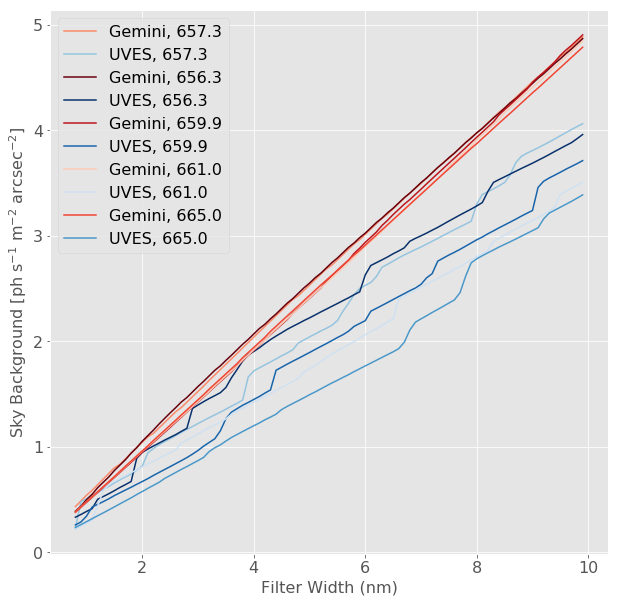

In [17]:
plt.figure(figsize = (10,10))
for key in (backdict):
    plt.plot(filterwidths,backdict[key][0],label='Gemini, %s'%key,color=reds(backdict[key][2]))
    plt.plot(filterwidths,backdict[key][1],label='UVES, %s'%key,color=blues(backdict[key][2]))
plt.xlabel('Filter Width (nm)')
plt.ylabel('Sky Background [ph s$^{-1}$ m$^{-2}$ arcsec$^{-2}$]')
plt.legend()

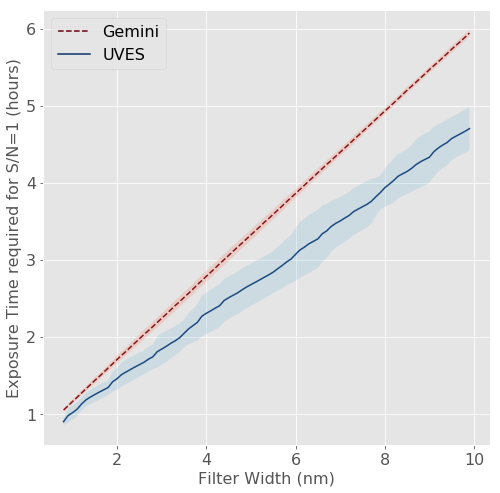

In [18]:
plt.figure(figsize = (8,8))
gem_exptime =[]
uves_exptime = []
for key in backdict:
    exptime = [calcTime2(1,SB_ph_three,B*u.photon/u.second/u.arcsec**2/u.m**2).to(u.hour).value for B in backdict[key][0]]
    gem_exptime.append(exptime)
    #plt.plot(filterwidths,exptime,label='Gemini, %s'%key,color=reds(backdict[key][2]))
    exptime = [calcTime2(1,SB_ph_three,B*u.photon/u.second/u.arcsec**2/u.m**2).to(u.hour).value for B in backdict[key][1]]
    uves_exptime.append(exptime)
    #plt.plot(filterwidths,exptime,label='UVES, %s'%key,color=blues(backdict[key][2]))

gem_sigma = np.std(np.array(gem_exptime),0)
gem_mean = np.mean(np.array(gem_exptime),0)
plt.plot(filterwidths,gem_mean,color=reds(1.0),linestyle='--',label='Gemini')
plt.fill_between(filterwidths,gem_mean-gem_sigma,gem_mean+gem_sigma,facecolor = reds(0.5),alpha=0.2,zorder=4)
uves_sigma = np.std(np.array(uves_exptime),0)
uves_mean = np.mean(np.array(uves_exptime),0)
plt.plot(filterwidths, uves_mean,color=blues(1.0),label='UVES')
plt.fill_between(filterwidths,uves_mean-uves_sigma,uves_mean+uves_sigma,facecolor = blues(0.5),alpha=0.2,zorder=4)

plt.xlabel('Filter Width (nm)')
plt.ylabel('Exposure Time required for S/N=1 (hours)')
plt.legend()

plt.savefig('SkyBackground_FilterWidthComparison.pdf')